In [1]:
working_directory = '/mnt/DataRAID/melismail/PDAC'
import os
os.chdir(working_directory)
from pickle_utils import write_pickle, read_pickle

import sys, cv2, math
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from os import listdir 
from os.path import isfile, join
from numpy import argmax
from tifffile import imread, imsave
from glob import glob

import sklearn
from sklearn import linear_model
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, preprocessing
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, classification_report
from scikitplot.metrics import plot_roc, plot_precision_recall, plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

np.random.seed(109)

In [2]:
base_path = '/mnt/DataRAID/melismail/PDAC/data'
preprocessing_path ='Preprocessing_mask_annotation'
model_path = 'InceptionV3' 
model_path2 = 'ResNet50'
model_path3 =  'VGG-16'
clustering_path = 'Classification'
plot_path = 'plots/Classification' 
class_path = 'two_classes/celltypes' #'two_classes/celltypes' #masks

In [3]:
df_classification_incept = read_pickle(path= os.path.join(base_path, clustering_path, class_path, model_path, f"{model_path}_classification_df.pkl"))
df_classification_res = read_pickle(path= os.path.join(base_path, clustering_path, class_path, model_path2, f"{model_path2}_classification_df.pkl"))
df_classification_vgg = read_pickle(path= os.path.join(base_path, clustering_path, class_path, model_path3, f"{model_path3}_classification_df.pkl"))

In [4]:
df_classification_incept["Feature Extration"] = "InceptionV3"
df_classification_res["Feature Extration"] = "ResNet50"
df_classification_vgg["Feature Extration"] = "VGG-16"

In [5]:
#df_combined = pd.concat([df_classification_incept,df_classification_res,df_classification_vgg],keys=['InceptionV3', 'ResNet50', 'VGG-16'])
#df_combined.reset_index().head()
df_combined = pd.concat([df_classification_incept,df_classification_res,df_classification_vgg])
df_combined.head()

,Model Name,Model,Balancer,Scaler,Cross-Validation Folds,Precision score,Recall score,F1-score score,Accuracy score,Area under the ROC curve (AUC),Grid_param,cm,classification_report,y_score,y_test,y_pred,Feature Extration
0,SVC,"SVC(C=1, class_weight='balanced', kernel='poly...",RandomOversampler,MinMaxScaler,5,0.842640,0.862338,0.852375,0.753219,0.601635,"{'C': 1, 'class_weight': 'balanced', 'kernel':...","[[19, 62], [53, 332]]",precision recall f1-score ...,"[[0.006405738102714522, 0.9935942618972856], [...","[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",InceptionV3
1,LogisticRegression,"LogisticRegression(C=0.1, class_weight='', max...",RandomOversampler,MinMaxScaler,5,0.831169,0.831169,0.831169,0.721030,0.522944,"{'C': 0.1, 'class_weight': '', 'penalty': 'non...","[[16, 65], [65, 320]]",precision recall f1-score ...,"[[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...","[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...",InceptionV3
2,RandomForestClassifier,"(DecisionTreeClassifier(max_features='sqrt', m...",RandomOversampler,MinMaxScaler,5,0.827957,1.000000,0.905882,0.828326,0.640693,"{'bootstrap': False, 'min_samples_split': 5, '...","[[1, 80], [0, 385]]",precision recall f1-score ...,"[[0.31033333333333335, 0.6896666666666668], [0...","[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",InceptionV3
3,SVC,"SVC(C=1, class_weight='', kernel='poly', proba...",RandomUndersampler,MinMaxScaler,5,0.841155,0.605195,0.703927,0.579399,0.607536,"{'C': 1, 'class_weight': '', 'kernel': 'poly'}","[[37, 44], [152, 233]]",precision recall f1-score ...,"[[0.49087991013185217, 0.5091200898681477], [0...","[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, ...",InceptionV3
4,LogisticRegression,"LogisticRegression(C=0.1, class_weight='', max...",RandomUndersampler,MinMaxScaler,5,0.857143,0.623377,0.721805,0.603004,0.627417,"{'C': 0.1, 'class_weight': '', 'penalty': 'l2'...","[[41, 40], [145, 240]]",precision recall f1-score ...,"[[0.536324736143259, 0.46367526385674096], [0....","[1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, ...","[0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, ...",InceptionV3


In [6]:
df_combined.rename(columns = {'F1-score score':'F1-score'}, inplace=True)

In [7]:
df_combined.columns

Index(['Model Name', 'Model', 'Balancer', 'Scaler', 'Cross-Validation Folds',
       'Precision score', 'Recall score', 'F1-score', 'Accuracy score',
       'Area under the ROC curve (AUC)', 'Grid_param', 'cm',
       'classification_report', 'y_score', 'y_test', 'y_pred',
       'Feature Extration'],
      dtype='object')

In [8]:
df_combined['Scaler'] = df_combined.apply(lambda x: 'no Scaler' if x["Scaler"] == "" else x["Scaler"], axis=1)
df_combined['Balancer'] = df_combined.apply(lambda x: 'no Balancer' if x["Balancer"] == "" else x["Balancer"], axis=1)

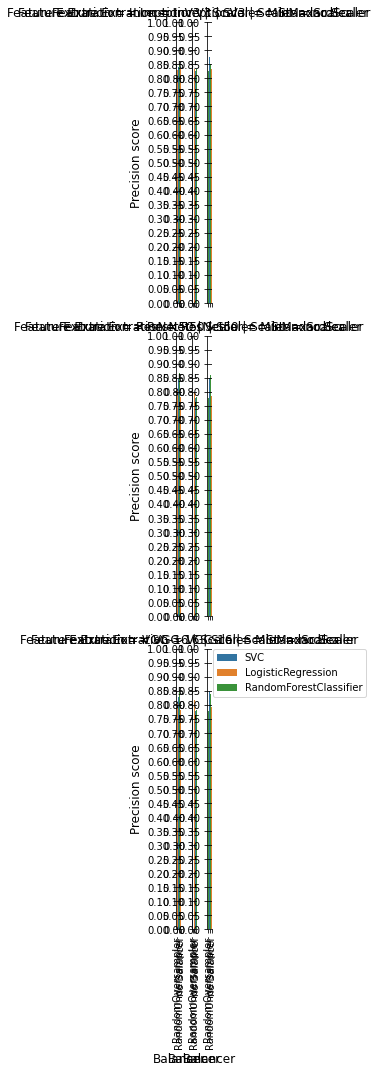

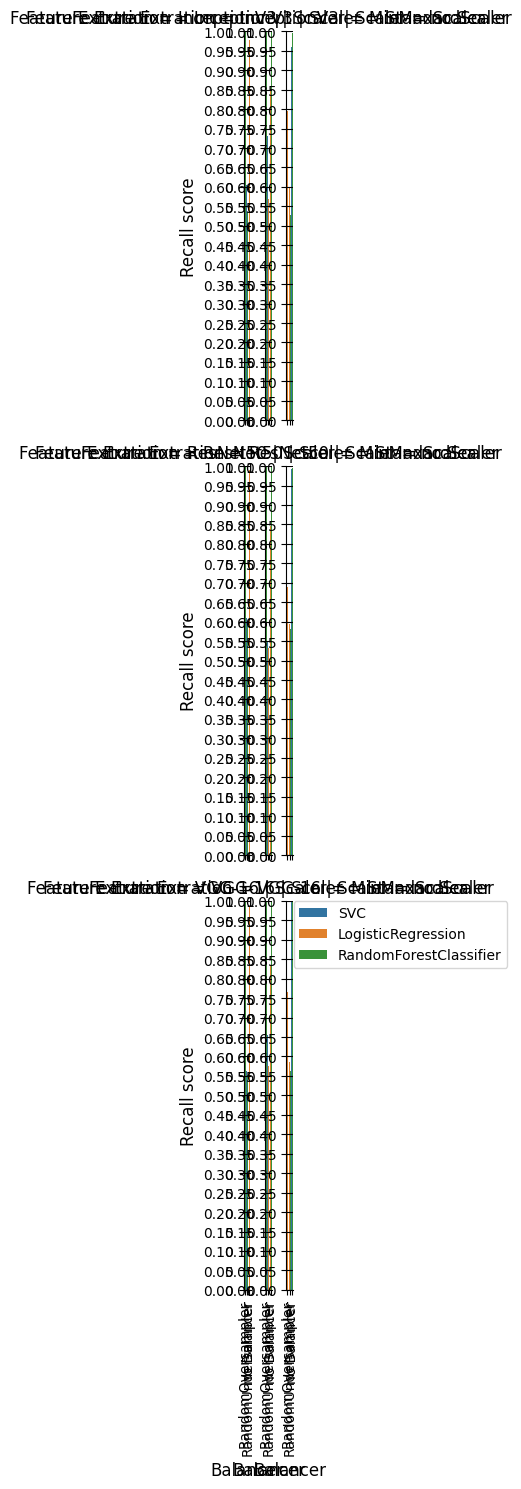

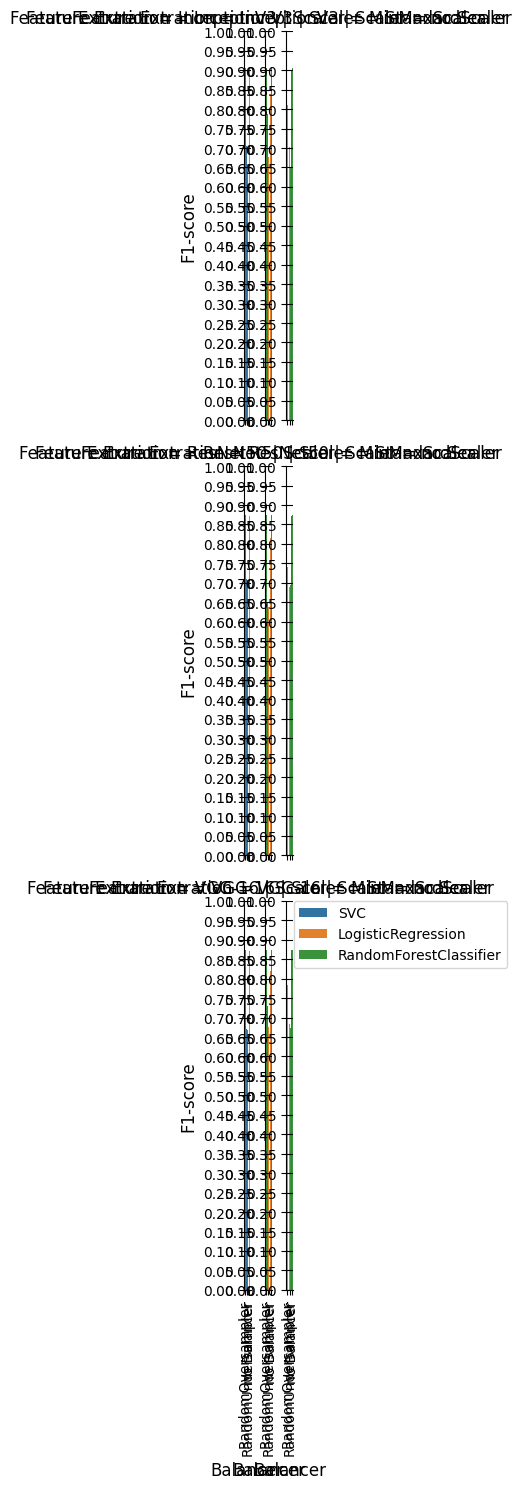

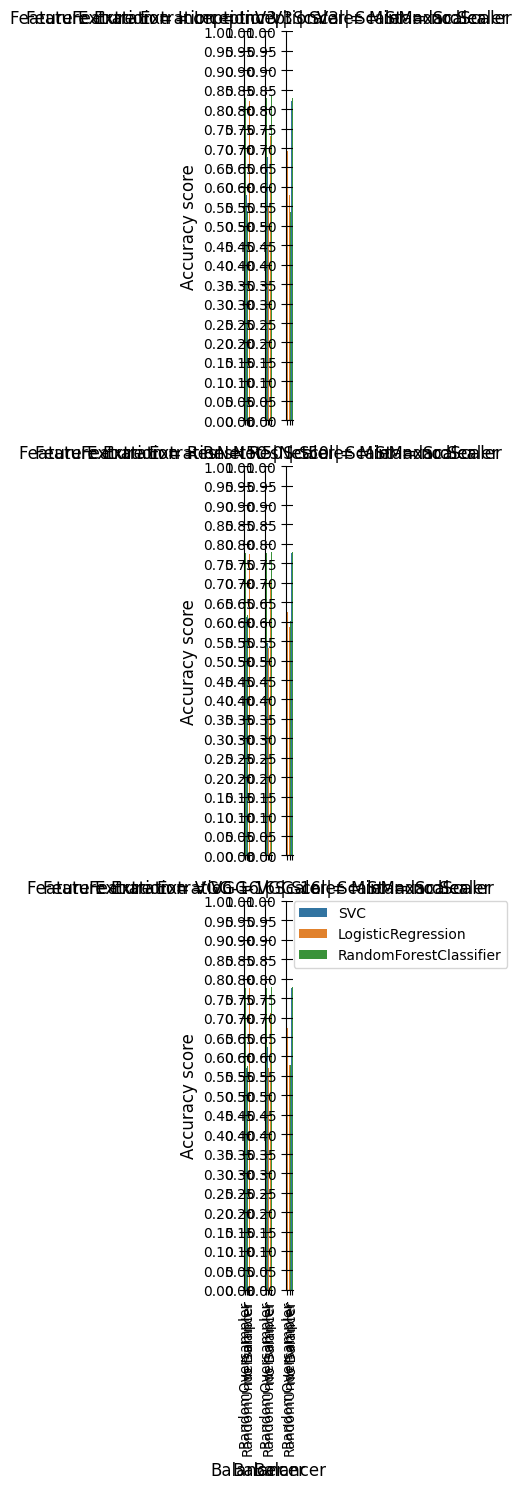

In [9]:
for i in ['Precision score', 'Recall score', 'F1-score', 'Accuracy score']: 
    plt.rcParams['axes.labelsize'] = 'large'
    g = sns.catplot(data=df_combined, hue="Model Name", y=i, kind='bar', row="Feature Extration", col="Scaler", x="Balancer", legend = False, sharey=False)
    g.set(ylim=(0,1))
    g.map(plt.xticks, rotation=90, color = 'k')
    g.map(plt.yticks, ticks=np.arange(0, 1.05, 0.05), color="k")
    g.map(plt.grid, axis="y", color="k")
    #plt.legend(framealpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()
    plt.subplots_adjust(wspace=2, left=0.8)
    #plt.savefig(f'lbl_multi_{i}_overview_catplot.png', dpi=400)
    plt.show()
    plt.close()

In [10]:
df_temp = pd.DataFrame(df_combined.apply(lambda x: roc_curve(x["y_test"], x["y_score"][:, 1]), axis=1).tolist(), columns=["tpr", "fpr", "threshold"])
    

In [26]:
df_combined_new = df_combined.reset_index().join(df_temp)
#df_combined_new_exploded = df_combined_new.explode(["fpr", "tpr", "threshold"])
df_combined_new["model_identifier"] = df_combined_new["Model Name"] + "; " + df_combined_new["Balancer"] + "; " +  df_combined_new["Scaler"] + "; " +  df_combined_new["Feature Extration"] + ";

#df_combined_new_exploded["Model Name"].unique()

In [ ]:
df_combined_new = df_combined_new[(df_combined_new["Model Name"] == "RandomForestClassifier") & (df_combined_new["Balancer"] != "RandomUndersampler")] 

In [ ]:
#df_combined_new_exploded = df_combined_new_exploded[(df_combined_new_exploded["Model Name"] == "RandomForestClassifier") & (df_combined_new_exploded["Balancer"] != "RandomUndersampler")] 
#df_combined_new_exploded["model_identifier"] = df_combined_new_exploded["Model Name"] + df_combined_new_exploded["Balancer"] + df_combined_new_exploded["Scaler"] + df_combined_new_exploded["Feature Extration"]
#print(df_combined_new_exploded.shape[0])

/tmp/ipykernel_22144/3097984588.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


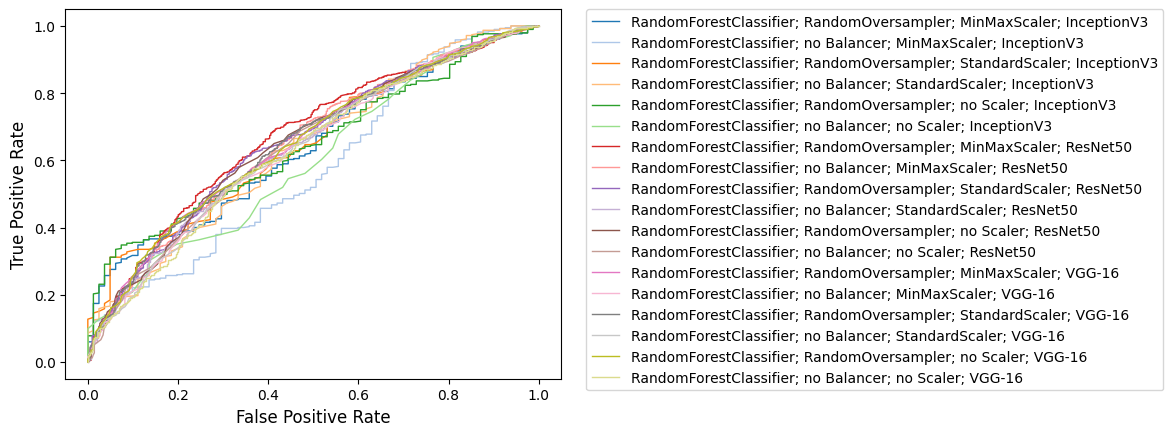

In [27]:
#sns.lineplot(data=df_combined_new_exploded, x= "fpr", y="tpr", hue="model_identifier")


for (fpr, tpr, ident), color in zip(df_combined_new[["fpr", "tpr", "model_identifier"]].itertuples(index=False), sns.color_palette("tab20", df_combined_new.shape[0])):
    plt.plot(
        tpr,
        fpr,
        color=color,
        lw=1,
        label=ident
)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig()
plt.show()


